# Compare virus libraries passaged C6/36 and Vero cells
There are 3 samples:

1. *CPEC* refers to the initial mutant library

2. *C636* refers to the library passaged in mosquito cells

3. *Vero* refers to the library passaged in Vero cells

## Import Python modules

In [1]:
import os
import glob
from pymodules.utils import showPDF

print("Using the following version of dms_tools:")
!dms_barcodedsubamplicons --version

Using the following version of dms_tools:
dms_barcodedsubamplicons 1.2.2


## Make the barcoded subamplicon alignments
We run `dms_barcodedsubamplicons` on each sample.

In [2]:
refseqfile = './data/seqs/NatalEDIIIonly.fa' # sequence of wildtype gene

samples = ['CPEC', 'Vero', 'C636']

# define names of R1 and R2 files
r1files = {
        'CPEC':'./data/fastq/J999_S90_L001_R1_001.fastq.gz',
        'Vero':'./data/fastq/vero8dpt_R1_001.fastq.gz',
        'C636':'./data/fastq/C636DMS_R1_001.fastq.gz',
        }
r2files = {}
for sample in samples:
    r2files[sample] = r1files[sample].replace('_R1_', '_R2_')
    if sample == 'CPEC':
        r2files[sample] = os.path.join(os.path.dirname(r2files[sample]), 
                'trimmed_{0}'.format(os.path.basename(r2files[sample])))

outprefixes = {}
for sample in samples:
    outprefixes[sample] = './results/alignments/{0}_'.format(sample)
    cmd = ' '.join(['dms_barcodedsubamplicons', outprefixes[sample], refseqfile, 
            r1files[sample], r2files[sample], '1,294,36,28 295,612,30,27', 
            '--barcodelength 8', '--R1trimlength 200', '--R2trimlength 180'])
    print("Running the following command for sample {0}:\n{1}\n".format(sample, cmd))
    log = !$cmd

Running the following command for sample CPEC:
dms_barcodedsubamplicons ./results/alignments/CPEC_ ./data/seqs/NatalEDIIIonly.fa ./data/fastq/J999_S90_L001_R1_001.fastq.gz ./data/fastq/trimmed_J999_S90_L001_R2_001.fastq.gz 1,294,36,28 295,612,30,27 --barcodelength 8 --R1trimlength 200 --R2trimlength 180

Running the following command for sample Vero:
dms_barcodedsubamplicons ./results/alignments/Vero_ ./data/seqs/NatalEDIIIonly.fa ./data/fastq/vero8dpt_R1_001.fastq.gz ./data/fastq/vero8dpt_R2_001.fastq.gz 1,294,36,28 295,612,30,27 --barcodelength 8 --R1trimlength 200 --R2trimlength 180

Running the following command for sample C636:
dms_barcodedsubamplicons ./results/alignments/C636_ ./data/seqs/NatalEDIIIonly.fa ./data/fastq/C636DMS_R1_001.fastq.gz ./data/fastq/C636DMS_R2_001.fastq.gz 1,294,36,28 295,612,30,27 --barcodelength 8 --R1trimlength 200 --R2trimlength 180



Now make summaries of the alignments.

Running the following command:
dms_summarizealignments ./results/alignments/3sample_summary_ barcodedsubamplicons ./results/alignments/CPEC_,CPEC ./results/alignments/Vero_,Vero ./results/alignments/C636_,C636


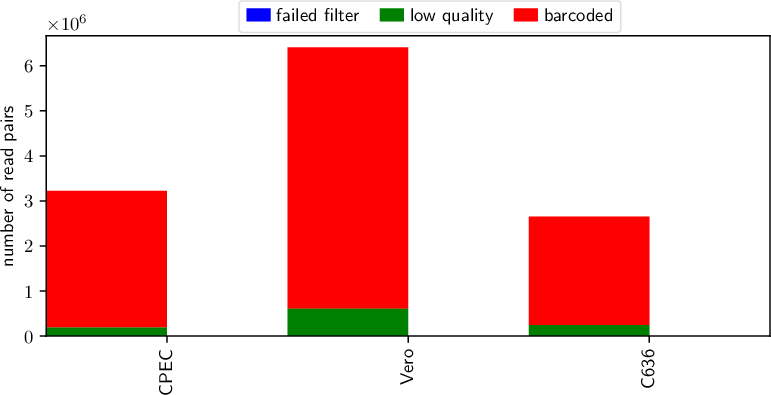

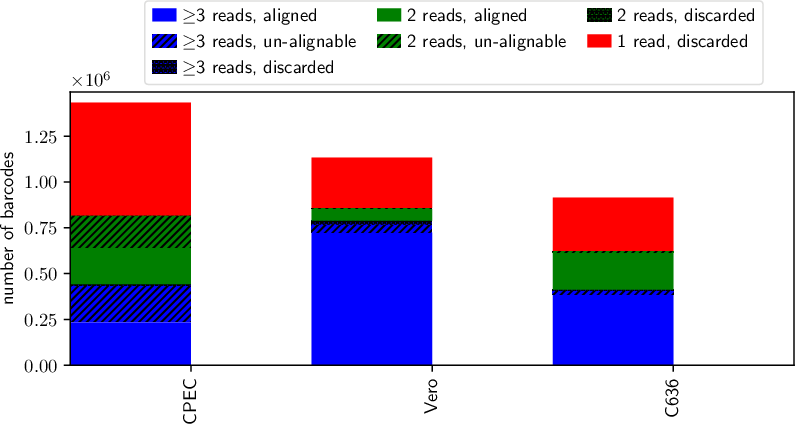

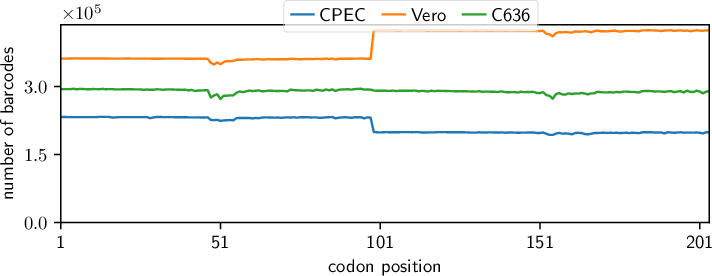

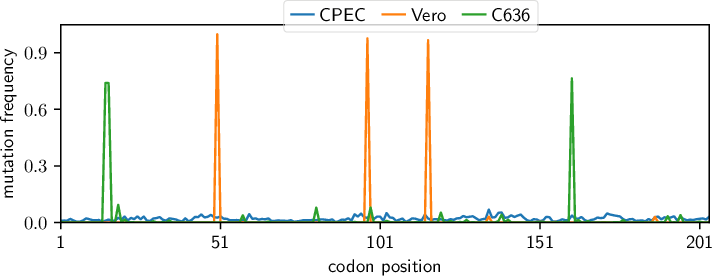

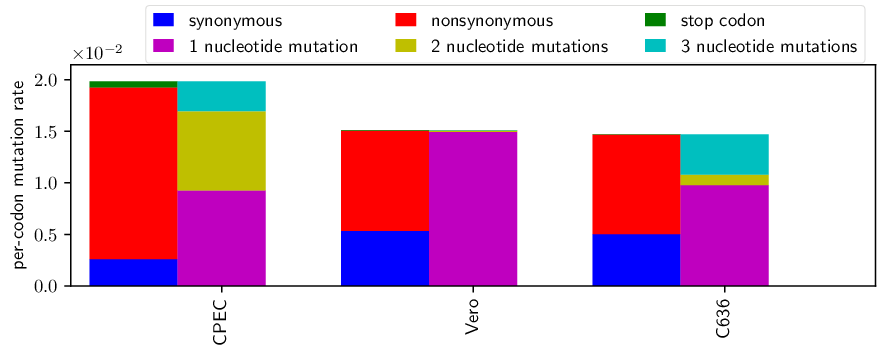

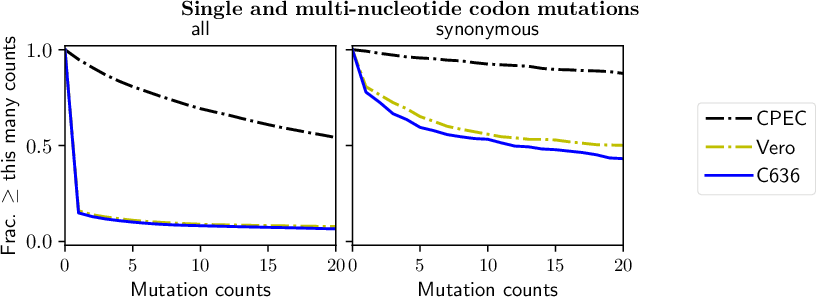

In [3]:
summaryprefix = './results/alignments/3sample_summary_'

cmd = ' '.join(['dms_summarizealignments', summaryprefix, 'barcodedsubamplicons'] +
        ['{0},{1}'.format(outprefixes[sample], sample) for sample in samples])
print("Running the following command:\n{0}".format(cmd))
log = !$cmd

suffixes = ['reads', 'barcodes', 'depth', 'mutdepth', 'mutfreqs', 'mutcounts_all']

for suffix in suffixes:
    showPDF('{0}{1}.pdf'.format(summaryprefix, suffix), width=500)

The sequence depth looks good.
But there is **extreme** bottlenecking of the libraries, where a few mutations have essentially gone to fixation in the Vero and C636 cells.
Either these are strongly beneficial mutations and the passage was so long that they swamped everything else out, or there was a bottleneck and they stochastically got through.
Also, given that they are at equal frequencies and you have a very high initial mutation frequency, they are probably linked.
So if they are selected, probably just one of them is strongly beneficial and the other(s) are hitchhiking along with it.

This could still be an interesting way to find host-specific mutations.
But you lose a lot of the power of the deep mutational scanning when you bottleneck your library down to such an extreme degree.
I would suggest doing much shorter passages while maintaining a much higher library diversity.

## Now infer differential selection and make logo plots
Given the bottlenecking described above, we essentially expect this to flag the couple of sites with extreme differences in selected mutations between conditions.

Computing differential selection with the following command:
dms_diffselection ./results/alignments/Vero_counts.txt ./results/alignments/C636_counts.txt ./results/diffsel/Vero_vs_C636_

Making logo plot with the following command:
dms_logoplot ./results/diffsel/Vero_vs_C636_mutdiffsel.txt ./results/diffsel/Vero_vs_C636__logoplot.pdf --nperline 34 --excludestop


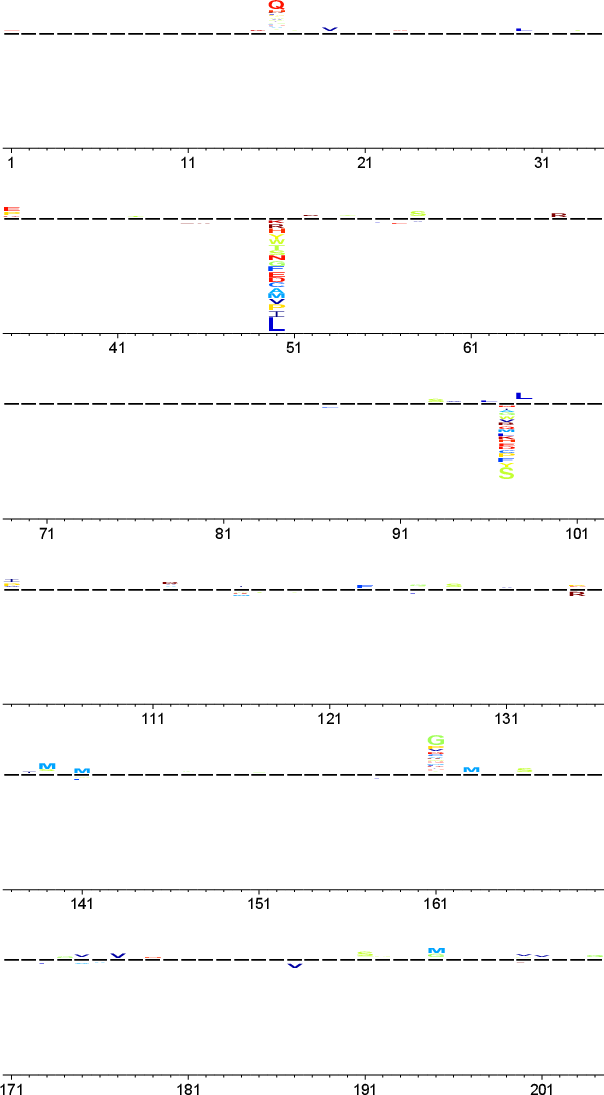

In [4]:
diffseldir = './results/diffsel/'
if not os.path.isdir(diffseldir):
    os.mkdir(diffseldir)

outprefix = os.path.join(diffseldir, 'Vero_vs_C636_')
cmd = ' '.join(['dms_diffselection', '{0}counts.txt'.format(outprefixes['Vero']), 
    '{0}counts.txt'.format(outprefixes['C636']), outprefix])
print("Computing differential selection with the following command:\n{0}".format(cmd))
log = !$cmd

logoplot = '{0}_logoplot.pdf'.format(outprefix)
cmd = ' '.join(['dms_logoplot', '{0}mutdiffsel.txt'.format(outprefix), logoplot, '--nperline 34',
    '--excludestop'])
print("\nMaking logo plot with the following command:\n{0}".format(cmd))
log = !$cmd

showPDF(logoplot)

Mutations above the line are preferred in *C636* cells over *Vero*, and ones below the line are preferred in *Vero* versus *C636*. 
But given the extreme bottlenecking, I would guess that at most a few of these mutations are preferred in one scenario versus the other, and that the other mutations may represent hitchhiking with the selected mutations.
I don't really know how well the idea behind `dms_diffselection` holds up when the libraries are bottlenecked to such an extreme.
You may be better off just comparing the two logoplots at the sites of interest.